In [1]:
import pandas as pd
import numpy as np
import datetime as dt

from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, RNN, Input, Bidirectional
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('ADANIPORTS_TRAIN.csv')
df.set_index('Date', drop=False, inplace=True)
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,,
2007-11-27,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15,NaN,9859619,0.3612
2007-11-28,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14,NaN,1453278,0.3172
2007-11-29,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14,NaN,1069678,0.2088
2007-11-30,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14,NaN,1260913,0.2735
2007-12-03,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14,NaN,816123,0.2741


In [3]:
df.tail()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,,
2021-03-24,2021-03-24,ADANIPORTS,EQ,738.55,741.00,750.50,697.65,708.15,706.85,726.81,21213413,1.541811e+15,273247.0,2649194,0.1249
2021-03-25,2021-03-25,ADANIPORTS,EQ,706.85,711.00,712.35,683.15,687.60,688.25,695.13,16860086,1.171993e+15,202143.0,2498300,0.1482
2021-03-26,2021-03-26,ADANIPORTS,EQ,688.25,698.00,710.70,692.60,702.00,703.05,702.76,12350673,8.679508e+14,156526.0,1209122,0.0979
2021-03-30,2021-03-30,ADANIPORTS,EQ,703.05,703.05,718.00,697.30,710.00,710.55,708.62,9109505,6.455144e+14,137556.0,1318011,0.1447
2021-03-31,2021-03-31,ADANIPORTS,EQ,710.55,705.00,719.90,698.60,702.40,702.40,710.23,7752226,5.505834e+14,105720.0,1464702,0.1889


In [4]:
df.isna().sum()

Date                    0
Symbol                  0
Series                  0
Prev Close              0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
VWAP                    0
Volume                  0
Turnover                0
Trades                866
Deliverable Volume      0
%Deliverble             0
dtype: int64

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Prev Close,3303.0,3.417532e+02,1.909332e+02,1.080000e+02,1.639000e+02,3.238000e+02,3.992250e+02,1.307450e+03
Open,3303.0,3.424021e+02,1.916240e+02,1.080000e+02,1.638750e+02,3.250000e+02,3.998500e+02,1.310250e+03
High,3303.0,3.491602e+02,1.965119e+02,1.104500e+02,1.671500e+02,3.304000e+02,4.058750e+02,1.324000e+03
Low,3303.0,3.352417e+02,1.867611e+02,1.056500e+02,1.606250e+02,3.191000e+02,3.926000e+02,1.270000e+03
Last,3303.0,3.418719e+02,1.911736e+02,1.080000e+02,1.636000e+02,3.243500e+02,3.990250e+02,1.308000e+03
Close,3303.0,3.418327e+02,1.910286e+02,1.080000e+02,1.639000e+02,3.238000e+02,3.992250e+02,1.307450e+03
VWAP,3303.0,3.424838e+02,1.918365e+02,1.083400e+02,1.639350e+02,3.251700e+02,3.998500e+02,1.302150e+03
Volume,3303.0,2.803631e+06,3.214700e+06,1.236600e+04,7.440895e+05,1.998100e+06,3.605832e+06,3.486808e+07
Turnover,3303.0,9.466057e+13,1.565239e+14,2.415857e+11,1.803507e+13,5.798856e+13,1.144723e+14,2.687719e+15
Trades,2437.0,4.250708e+04,3.534262e+04,3.660000e+02,2.070400e+04,3.567200e+04,5.275700e+04,4.696520e+05


In [6]:
df.drop(['Symbol','Series'],axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3303 entries, 2007-11-27 to 2021-03-31
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                3303 non-null   object 
 1   Prev Close          3303 non-null   float64
 2   Open                3303 non-null   float64
 3   High                3303 non-null   float64
 4   Low                 3303 non-null   float64
 5   Last                3303 non-null   float64
 6   Close               3303 non-null   float64
 7   VWAP                3303 non-null   float64
 8   Volume              3303 non-null   int64  
 9   Turnover            3303 non-null   float64
 10  Trades              2437 non-null   float64
 11  Deliverable Volume  3303 non-null   int64  
 12  %Deliverble         3303 non-null   float64
dtypes: float64(10), int64(2), object(1)
memory usage: 361.3+ KB


<AxesSubplot:>

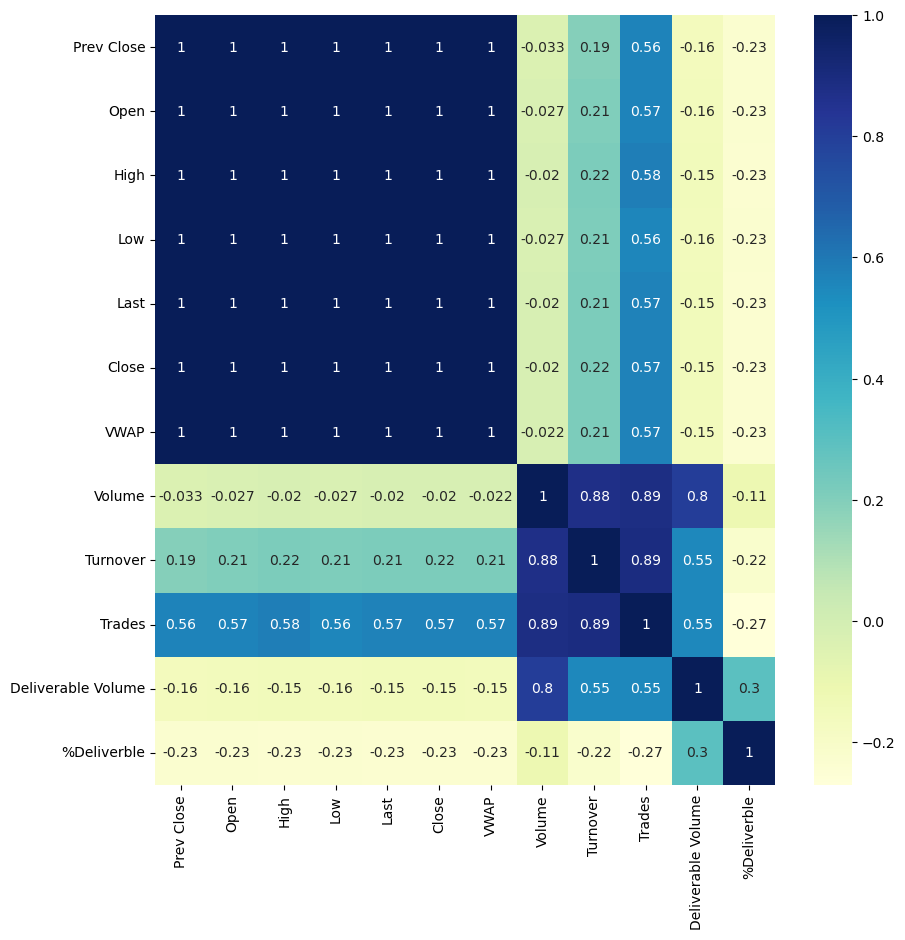

In [7]:
# correlation

plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), cmap='YlGnBu', annot=True)

In [8]:
df.head()

,Date,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,
2007-11-27,2007-11-27,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15,NaN,9859619,0.3612
2007-11-28,2007-11-28,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14,NaN,1453278,0.3172
2007-11-29,2007-11-29,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14,NaN,1069678,0.2088
2007-11-30,2007-11-30,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14,NaN,1260913,0.2735
2007-12-03,2007-12-03,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14,NaN,816123,0.2741


'Date','Open','High','Low','Volume','VWAP' are highly correlated

<AxesSubplot:xlabel='Date'>

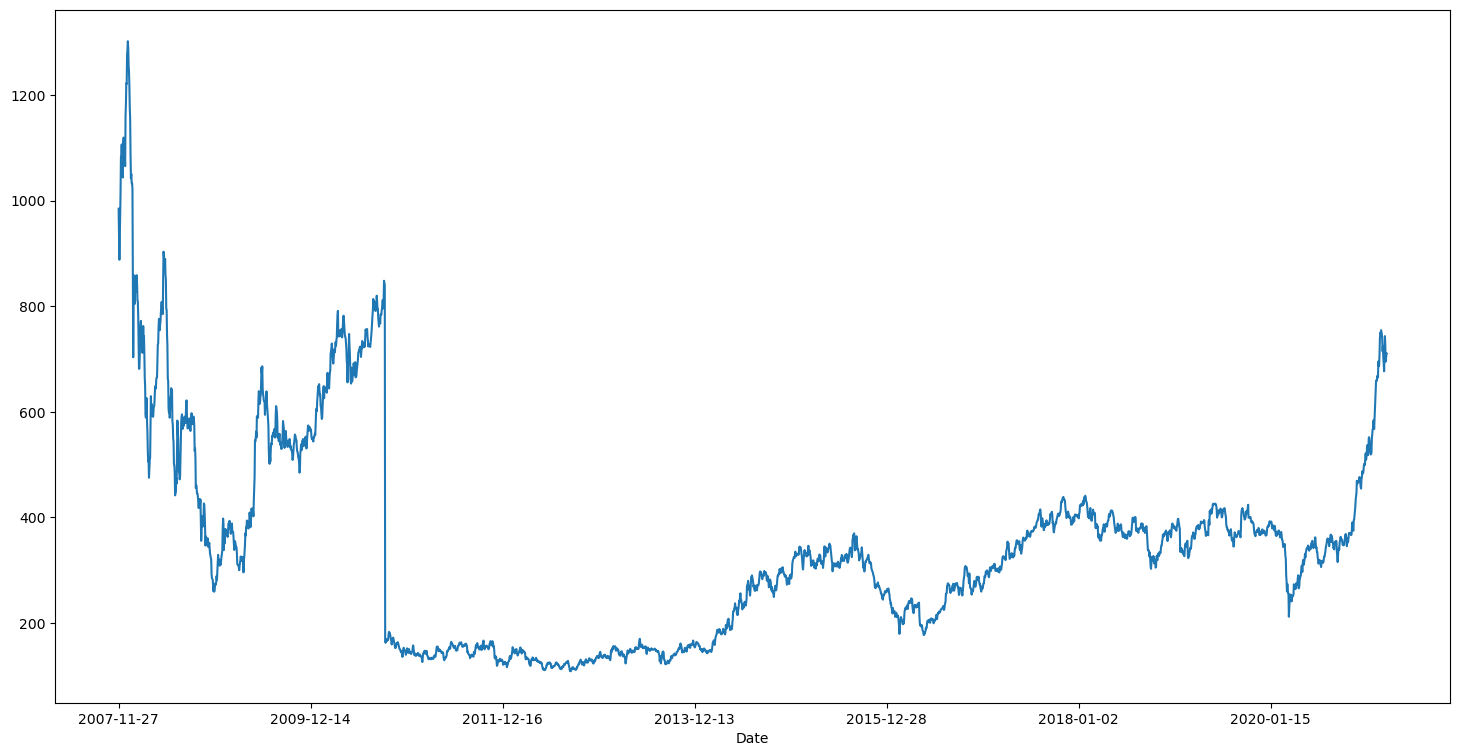

In [9]:
df.VWAP.plot(figsize=(18,9))

## Feature Engineering

### RNN n Friends

In [10]:
def rmse(x, y):
    return np.round(np.sqrt(mean_squared_error(x,y)), 4)   

In [11]:
def create_dataset(df, look_back, look_ahead):
    xdat, ydat = [], []
    for i in range(len(df) - look_back - look_ahead):
        xdat.append(df[i:i+look_back,0])
        ydat.append(df[i+look_back: i+look_back+look_ahead,0])
    
    xdat, ydat = np.array(xdat), np.array(ydat).reshape(-1, look_ahead)
    return xdat, ydat

In [12]:
def prepare_split(xdat, ydat, cutoff=5000, timesteps=50):
    xtrain, xvalid = xdat[:cutoff, :], xdat[cutoff:,]
    ytrain, yvalid = ydat[:cutoff, :], ydat[cutoff:,]
    
    # reshape into [batch size, time steps, dimensionality]
    xtrain = xtrain.reshape(-1, timesteps, 1)
    xvalid = xvalid.reshape(-1, timesteps, 1)
    
    return xtrain, ytrain, xvalid, yvalid

<AxesSubplot:xlabel='Date'>

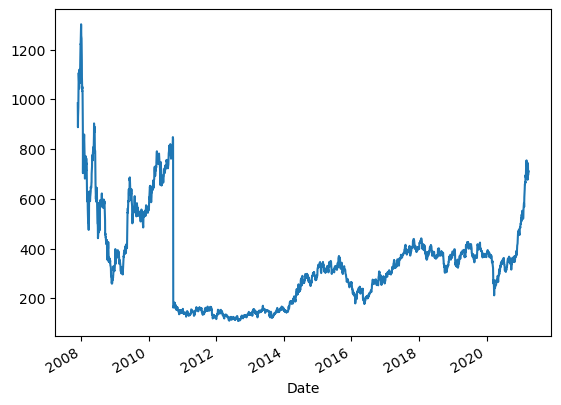

In [13]:
df = pd.read_csv("ADANIPORTS_TRAIN.csv", usecols=['Date', 'VWAP'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.VWAP.plot()

In [14]:
df

,VWAP
Date,
2007-11-27,984.72
2007-11-28,941.38
2007-11-29,888.09
2007-11-30,929.17
2007-12-03,965.65
...,...
2021-03-24,726.81
2021-03-25,695.13
2021-03-26,702.76


    When dealing with time series through RNN we typically - wrappers like Kats or darts notwithstanding - need to format the input data into a shape [batch size, time steps, dimensionality] where the last one is 1 for univariate series (single step ahead predictions) and more for multivariate ones (including univariate series + covariates

In [15]:
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [16]:
# use 50 historical observation and predict 1 step ahead

look_back = 50
look_ahead = 1

xdat, ydat = create_dataset(df, look_back, look_ahead)

print(xdat.shape, ydat.shape)

(3252, 50) (3252, 1)


Our prepare_split function takes care of reshaping the data into [batch size, time steps, dimensionality]

In [17]:
xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 3000, timesteps = look_back)

print(xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape)

(3000, 50, 1) (252, 50, 1) (3000, 1) (252, 1)


In [17]:
# simple RNN model

def create_model():
    model = Sequential()
    model.add(SimpleRNN(10, input_shape=[None, 1]))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                120       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [18]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 20, mode = 'min', verbose = 1,
                           restore_best_weights = True)

model.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
           epochs = 20, 
           batch_size = 16, 
           callbacks=[ early_stop])

Epoch 1/20
188/188 [==============================] - 4s 14ms/step - loss: 0.0553 - val_loss: 0.0065
Epoch 2/20
188/188 [==============================] - 2s 9ms/step - loss: 0.0074 - val_loss: 0.0036
Epoch 3/20
188/188 [==============================] - 2s 9ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 4/20
188/188 [==============================] - 2s 8ms/step - loss: 0.0041 - val_loss: 0.0044
Epoch 5/20
188/188 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 6/20
188/188 [==============================] - 2s 8ms/step - loss: 0.0025 - val_loss: 9.3143e-04
Epoch 7/20
188/188 [==============================] - 2s 8ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 8/20
188/188 [==============================] - 2s 9ms/step - loss: 0.0015 - val_loss: 5.4715e-04
Epoch 9/20
188/188 [==============================] - 2s 9ms/step - loss: 0.0013 - val_loss: 8.1787e-04
Epoch 10/20
188/188 [==============================] - 2s 9ms/step - loss: 0.0011 - val

In [19]:
y_pred = model.predict(xvalid)
y_pred = scaler.inverse_transform(y_pred)
yvalid1 = scaler.inverse_transform(yvalid)

8/8 [==============================] - 0s 4ms/step


In [20]:
print('RMSE:'+str(rmse(y_pred, scaler.inverse_transform(yvalid))))
print('RMSE:'+str(np.sqrt(mean_squared_error(y_pred, yvalid1))))

RMSE:12.7322
RMSE:12.732221509653773


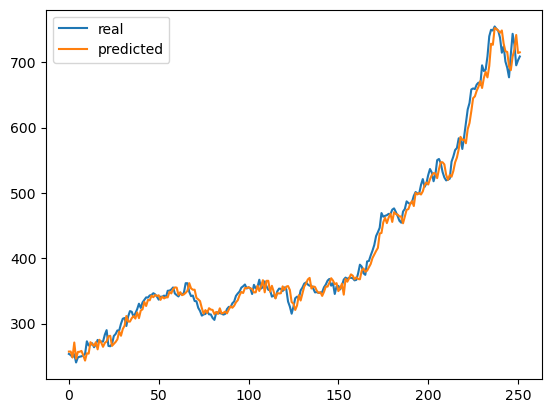

In [21]:
plt.plot(yvalid1, label = 'real')
plt.plot(y_pred, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()

Let's try with 2 RNN layer

By default a recurrent layer only returns the final output - if we want the output for each time step we set return_sequences = True

In [22]:
def create_model():
    model = Sequential()
    model.add(SimpleRNN(10, input_shape=[None, 1], return_sequences=True))
    model.add(SimpleRNN(10, input_shape=[None, 1]))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 10)          120       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(xtrain, ytrain, 
          validation_data=(xvalid, yvalid),
          epochs = 5, 
          batch_size = 16, 
          callbacks=[ early_stop])

y_pred = model.predict(xvalid)
y_pred = scaler.inverse_transform(y_pred)
yvalid1 = scaler.inverse_transform(yvalid)
print('RMSE: ' + str(rmse(y_pred, yvalid1)))

Epoch 1/5
188/188 [==============================] - 7s 26ms/step - loss: 0.0056 - val_loss: 4.6792e-04
Epoch 2/5
188/188 [==============================] - 4s 23ms/step - loss: 3.6794e-04 - val_loss: 1.2622e-04
Epoch 3/5
188/188 [==============================] - 4s 20ms/step - loss: 3.1718e-04 - val_loss: 1.0687e-04
Epoch 4/5
188/188 [==============================] - 5s 25ms/step - loss: 3.0515e-04 - val_loss: 9.8276e-05
Epoch 5/5
8/8 [==============================] - 1s 8ms/step
RMSE: 11.868


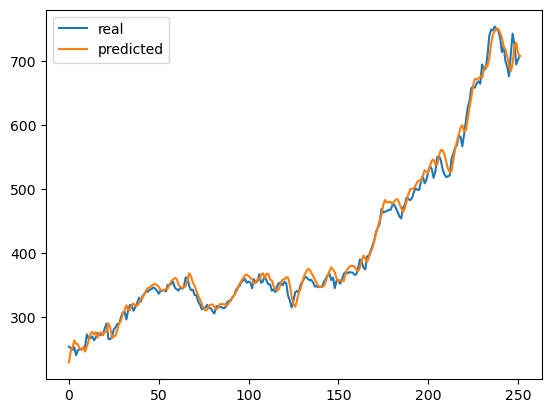

In [24]:
plt.plot(yvalid1, label = 'real')
plt.plot(y_pred, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()

Our model definitely got better!

### LSTM

A second popular approach to handling the issues with RNN is using Long Short-Term Memory units:

    * LSTM have two more gates compared to GRU: forget and output.

    * Forget gate: controls what is kept vs forgotten, from previous cell state. In laymen terms, it will decide how much information from the previous state should be kept and forget remaining.

    * Output gate: controls which parts of the cell are output to the hidden state. It will determine what the next hidden state will be.

In [25]:
def create_model(out_dim):    
    
    model=Sequential()
    model.add(LSTM(10,input_shape= [None,1], return_sequences = True))
    model.add(LSTM(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model = create_model(look_ahead)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 10)          480       
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit(xtrain, ytrain,
          validation_data=(xvalid, yvalid),
          epochs = 10, 
          batch_size = 16, 
          callbacks=[early_stop])

y_pred = model.predict(xvalid)
y_pred = scaler.inverse_transform(y_pred)
yvalid1 = scaler.inverse_transform(yvalid)
print('RMSE:'+ str(rmse(y_pred, yvalid1)))

Epoch 1/10
188/188 [==============================] - 13s 43ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 2/10
188/188 [==============================] - 6s 34ms/step - loss: 9.7970e-04 - val_loss: 3.4036e-04
Epoch 3/10
188/188 [==============================] - 7s 35ms/step - loss: 8.2050e-04 - val_loss: 2.3418e-04
Epoch 4/10
188/188 [==============================] - 7s 35ms/step - loss: 6.8348e-04 - val_loss: 2.4807e-04
Epoch 5/10
188/188 [==============================] - 6s 34ms/step - loss: 6.0506e-04 - val_loss: 1.9636e-04
Epoch 6/10
188/188 [==============================] - 7s 38ms/step - loss: 5.5793e-04 - val_loss: 2.6318e-04
Epoch 7/10
188/188 [==============================] - 7s 36ms/step - loss: 5.2533e-04 - val_loss: 3.1427e-04
Epoch 8/10
188/188 [==============================] - 7s 38ms/step - loss: 5.0615e-04 - val_loss: 1.6732e-04
Epoch 9/10
188/188 [==============================] - 7s 37ms/step - loss: 4.4365e-04 - val_loss: 1.3919e-04
Epoch 10/10
8/8 [=========

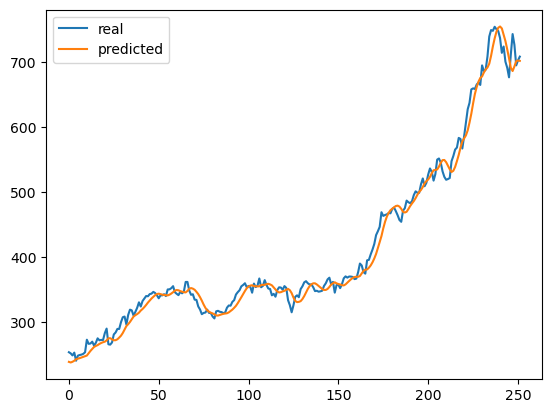

In [27]:
plt.plot(yvalid1, label = 'real')
plt.plot(y_pred, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()